In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [2]:
df = pd.read_csv("data/lesson_4_sam.csv", index_col=[0, 1], header=[0, 1]).map(float).fillna(0)
assert np.allclose(df.sum(axis=0), df.sum(axis=1))
df

Factor         Institution                  \
                                   Labor Capital   Household   Firms    Govt   
Factor      Labor                    0.0     0.0         0.0     0.0     0.0   
            Capital                  0.0     0.0         0.0     0.0     0.0   
Institution Household             7200.0     0.0         0.0  2800.0     0.0   
            Firms                    0.0  2800.0         0.0     0.0     0.0   
            Govt                     0.0     0.0      3000.0     0.0     0.0   
Production  Agriculture              0.0     0.0      1700.0     0.0   400.0   
            Industry                 0.0     0.0      1200.0     0.0  1500.0   
            Services                 0.0     0.0      3400.0     0.0  2300.0   
Activities  Agriculture              0.0     0.0         0.0     0.0     0.0   
            Industry                 0.0     0.0         0.0     0.0     0.0   
            Services                 0.0     0.0         0.0     0.0     0.0   
Other       Capital Accumulation     0.0     0.0       700.0     0.0   250.0   

                                  Production                    Activities  \
                                 Agriculture Industry Services Agriculture   
Factor      Labor                        0.0      0.0      0.0      1300.0   
            Capital                      0.0      0.0      0.0       200.0   
Institution Household                    0.0      0.0      0.0         0.0   
            Firms                        0.0      0.0      0.0         0.0   
            Govt                       150.0   1020.0    280.0         0.0   
Production  Agriculture                  0.0      0.0      0.0      1000.0   
            Industry                     0.0      0.0      0.0      2010.0   
            Services                     0.0      0.0      0.0       490.0   
Activities  Agriculture               5000.0      0.0      0.0         0.0   
            Industry                     0.0  11000.0      0.0         0.0   
            Services                     0.0      0.0   9500.0         0.0   
Other       Capital Accumulation         0.0      0.0      0.0         0.0   

                                                                  Other  
                                 Industry Services Capital Accumulation  
Factor      Labor                  1900.0   4000.0                  0.0  
            Capital                2100.0    500.0                  0.0  
Institution Household                 0.0      0.0                  0.0  
            Firms                     0.0      0.0                  0.0  
            Govt                      0.0      0.0                  0.0  
Production  Agriculture            1000.0   1000.0                 50.0  
            Industry               3510.0   3000.0                800.0  
            Services               2490.0   1000.0                100.0  
Activities  Agriculture               0.0      0.0                  0.0  
            Industry                  0.0      0.0                  0.0  
            Services                  0.0      0.0                  0.0  
Other       Capital Accumulation      0.0      0.0                  0.0

In [3]:
variable_info = [
    # Firm variables (7)
    Variable(name="Y", dims="i", description="Final output in the <dim:i> sector"),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="I_d",
        dims="i",
        extend_subscript=True,
        description="Investment capital demanded by the <dim:i> sector",
    ),
    # Prices (7)
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    Variable(
        name="P_Y",
        dims="i",
        extend_subscript=True,
        description="Final good price in the <dim:i> sector, before taxes",
    ),
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    # Household Variables (6)
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of <dim:i> goods"),
    Variable(
        name="I_s", extend_subscript=True, description="Investment capital supplied by households"
    ),
    Variable(name="S", description="Household savings"),
    Variable(name="income", latex_name="Omega", description="Household income, before taxes"),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    # Government variables (3)
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G",
        dims="i",
        extend_subscript=True,
        description="Government consumption of <dim:i> goods",
    ),
    Variable(
        name="S_G",
        extend_subscript=True,
        positive=None,
        description="Investment capital supplied by government",
    ),
    # Misc (1)
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]


param_info = [
    # Production Parameters
    Parameter(
        "alpha",
        dims="i",
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter(
        "alpha_k",
        dims="i",
        extend_subscript=True,
        description="Share of capital investment demanded by the <dim:i> sector",
    ),
    Parameter("A", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",
    ),
    Parameter(
        name="phi_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    # Tax parameters
    Parameter("tau", dims="i", description="Sales tax rate on final goods in the <dim:i> sector"),
    Parameter("tau_income", latex_name=r"\tau_{\Omega}", description="Income tax rate"),
    # Household parameters
    Parameter(
        "gamma",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter("mps", latex_name="phi", description="Household marginal propensity to save"),
    # Government parameters
    Parameter(
        "alpha_G",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    # Exogenous values
    Parameter("L_s", description="Exogenous labor supply"),
    Parameter("K_s", description="Exogenous capital supply"),
    Parameter("P_Ag_bar", latex_name=r"\bar{P}_{Ag}", description="Numeraire price"),
    Parameter(
        "S_G_bar",
        latex_name=r"\bar{S}_G",
        description="Exogenous level of governmnet savings",
        positive=None,
    ),
]

equations = [
    # Frim Block
    # # Firm Equations
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC[None] * P_VC[None] = (P[:, None] * X).sum(axis=0).ravel()",
    ),
    Equation("Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC[None]"),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor-capital",
        "VA = A * (alpha * K_d**((phi_VA - 1) / phi_VA) +"
        "(1 - alpha) * L_d**((phi_VA - 1) / phi_VA)) ** (phi_VA / (phi_VA - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for capital", "K_d = VA / A * (alpha * P_VA * A / r) ** phi_VA"
    ),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = VA / A * ((1 - alpha) * A * P_VA / w) ** phi_VA",
    ),
    Equation("<dim:i> sector demand for investment capital", "P * I_d = alpha_k * I_s"),
    # Government block
    Equation(
        "Government budget constraint",
        "G + S_G = tau_income * income + (tau * P_Y * Y).sum()",
    ),
    Equation("Government consumption of <dim:i> sector goods", "P * C_G = alpha_G * G"),
    Equation("Sector <dim:i> after-tax price", "P = (1 + tau) * P_Y"),
    Equation("Exogenous government savings", "S_G = S_G_bar"),
    # Household block
    Equation("Household pre-tax income", "income = w * L_s + r * K_s"),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    Equation("Household utility", "U = (C**gamma).prod()"),
    Equation("Household demand for good <dim:i>", "C * P = gamma * (1 - mps) * net_income"),
    Equation("Household savings", "S = mps * net_income"),
    # Economic equilibrium
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    Equation("Labor market clearing", "L_s = L_d.sum()"),
    Equation("Capital market clearing", "K_s = K_d.sum()"),
    Equation("<dim:i> sector goods market clearing", "Y = C + X.sum(axis=1) + C_G + I_d"),
    Equation("Numeraire", "P[0] = P_Ag_bar"),
]

assert len(variable_info) == len(
    equations
), f"Found {len(variable_info)} variables but {len(equations)} equations"

In [4]:
sectors = ["Ag", "Ind", "Serv"]

n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=False,
    backend="pytensor",
    mode="JAX",
)

In [5]:
def calibrate_model(
    income_tax_revenue,
    sales_tax_revenue,
    S,
    S_G,
    L_d,
    K_d,
    C,
    C_G,
    Y,
    X,
    I_d,
    phi_VA,
    variables,
    parameters,
):
    rho_VA = (phi_VA - 1) / phi_VA

    # Normalize prices to 1
    w = 1.0
    r = 1.0
    P_VA = np.ones(n_sectors)
    P_VC = np.ones(n_sectors)
    P_Y = np.ones(n_sectors)

    # Zero the residual
    resid = 0.0

    # Factor supplies
    L_s = L_d.sum()
    K_s = K_d.sum()

    # Tax rates
    tau = sales_tax_revenue / (Y - sales_tax_revenue)
    P = P_Y * (1 + tau)

    # Numeraire
    P_Ag_bar = P[0]

    X /= P[:, None]
    C /= P
    C_G /= P
    I_d /= P
    Y /= P

    # Firm calibration
    VA = (w * L_d + r * K_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha = r * K_d ** (1 / phi_VA) / ((r * K_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    A = VA * (alpha * K_d**rho_VA + (1 - alpha) * L_d**rho_VA) ** (-1 / rho_VA)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    income = w * L_s + r * K_s
    tau_income = income_tax_revenue / income
    net_income = (1 - tau_income) * income

    mps = S / net_income
    consumption_spend = (1 - mps) * net_income

    gamma = P * C / consumption_spend

    U = (C**gamma).prod()

    # Exogenous government spending level
    S_G_bar = S_G

    G = (P * C_G).sum()
    alpha_G = (P * C_G) / G

    I_s = (P * I_d).sum()
    alpha_k = P * I_d / I_s

    d = {}
    for obj in variables + parameters:
        d[obj.name] = locals()[obj.name]

    return d

In [6]:
initial_data = {
    "income_tax_revenue": df.loc[("Institution", "Govt"), ("Institution", "Household")],
    "sales_tax_revenue": df.loc[("Institution", "Govt"), "Production"].values,
    "S": df.loc[("Other", "Capital Accumulation"), ("Institution", "Household")],
    "S_G": df.loc[("Other", "Capital Accumulation"), ("Institution", "Govt")],
    "L_d": df.loc[("Factor", "Labor"), "Activities"].values,
    "K_d": df.loc[("Factor", "Capital"), "Activities"].values,
    "I_d": df.loc["Production", ("Other", "Capital Accumulation")].values,
    "C": df.loc["Production", ("Institution", "Household")].values,
    "C_G": df.loc["Production", ("Institution", "Govt")].values,
    "Y": df.loc["Production", :].sum(axis=1).values,
    "X": df.loc["Production", "Activities"].values,
}

econometric_estimates = {"phi_VA": np.ones(n_sectors) * 10.0}

In [7]:
calibrated_data = calibrate_model(
    **(initial_data | econometric_estimates), variables=mod.variables, parameters=mod.parameters
)
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


## Policy Simulation -- Tax Cut

In [8]:
sim_result = mod.simulate(
    calibrated_data, final_delta_pct={"tau_income": calibrated_data["tau_income"] * 0}
)

In [10]:
mod.check_for_equilibrium(sim_result["euler"])

Equilibrium found! Total squared error: 0.000000


In [11]:
mod.check_for_equilibrium(sim_result["optimizer"])

Equilibrium found! Total squared error: 0.000000


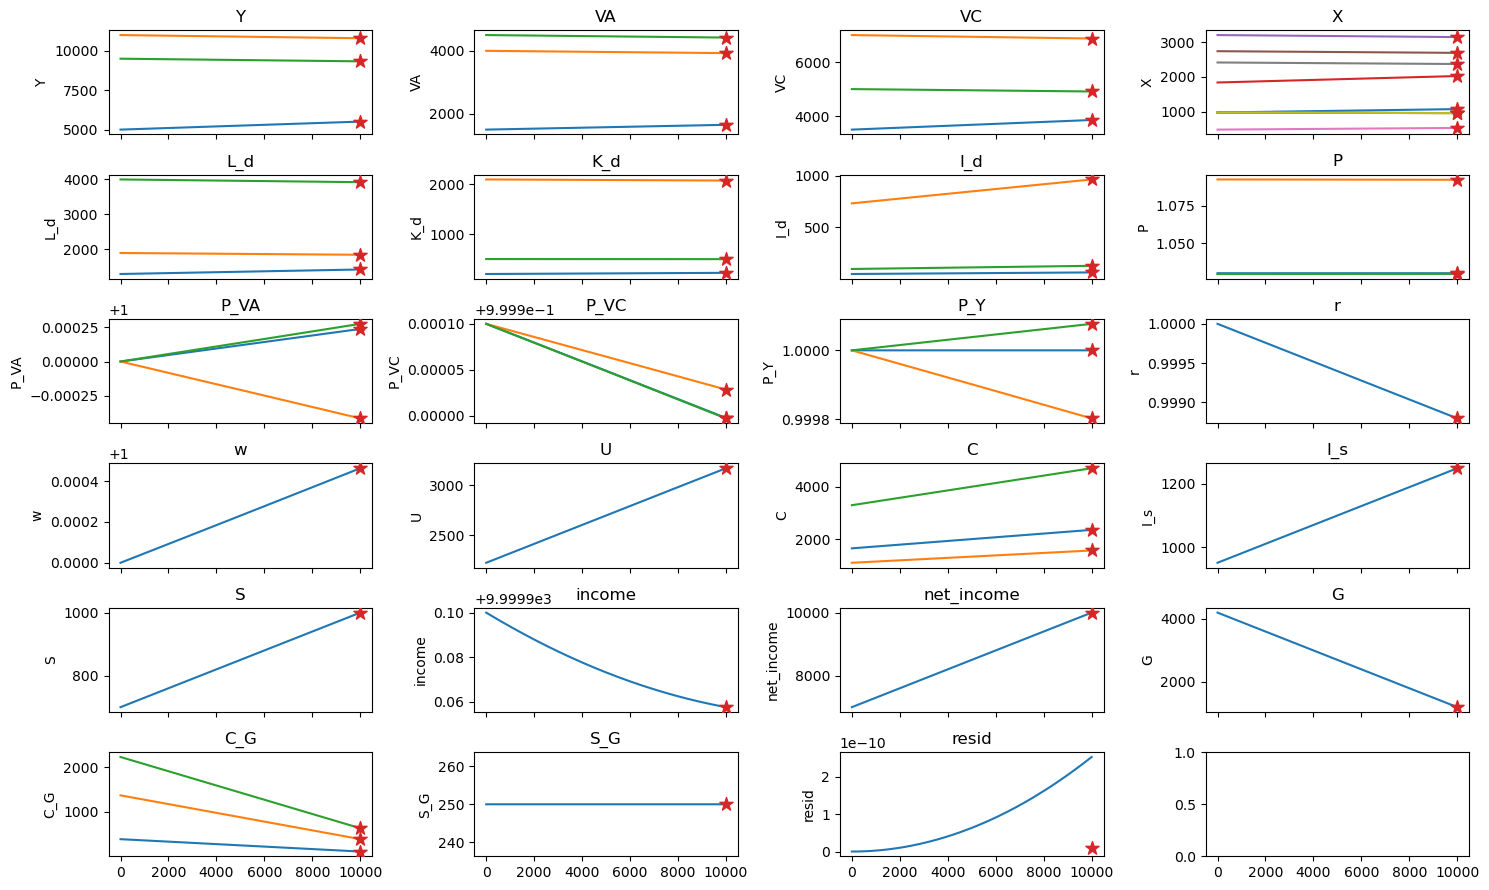

In [19]:
fig, ax = plt.subplots(6, 4, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = sim_result["euler"].variables[var]
    if data.ndim > 2:
        data = data.stack(pair=["i", "j"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)

    optim_data = sim_result["optimizer"].variables[var]
    scatter_grid = np.full(int(np.prod(optim_data.shape)), data.coords["step"].max())
    axis.scatter(
        scatter_grid, optim_data.values.ravel(), marker="*", color="tab:red", zorder=10, s=100
    )
fig.tight_layout()

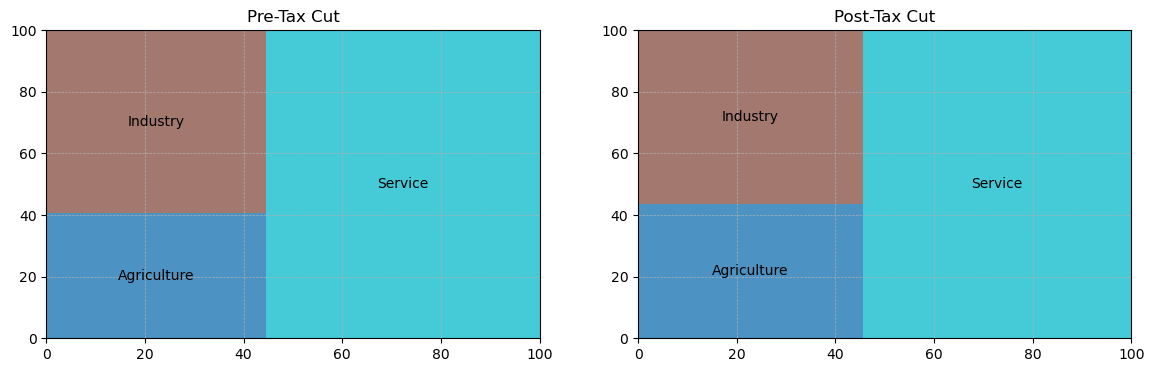

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Service"}

long_sectors = [short_to_long[x] for x in sectors]
cmap = plt.cm.tab10([0, 0.5, 1.0])

squarify.plot(sizes=calibrated_data["L_d"], label=long_sectors, alpha=0.8, ax=ax[0], color=cmap)
squarify.plot(
    sizes=sim_result["optimizer"].variables["L_d"],
    label=long_sectors,
    alpha=0.8,
    ax=ax[1],
    color=cmap,
)
for axis, title in zip(fig.axes, ["Pre-Tax Cut", "Post-Tax Cut"]):
    axis.grid(ls="--", lw=0.5)
    axis.set(title=title)

# Uncertainty

## Uncertainty in Simulations

In [54]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from cge_modeling.pytensorf.compile import compile_cge_model_to_pytensor_Op
from cge_modeling.pytensorf.optimize import root

coords = {"sector": sectors, "sector_bis": sectors}


def dims_to_nice_names(obj):
    convert_dict = {"i": "sector", "j": "sector_bis"}
    return tuple([convert_dict.get(dim, None) for dim in obj.dims])


with pm.Model(coords=coords):
    phi_VA_offset = pm.Gamma("phi_VA_offset", alpha=2, beta=0.1, dims=["sector"])
    phi_VA = pm.Deterministic("phi_VA", 3 + phi_VA_offset, dims=["sector"])
    input_dict = deepcopy(initial_data)
    input_dict["phi_VA"] = phi_VA

    calib_dict = calibrate_model(**input_dict, variables=mod.variables, parameters=mod.parameters)
    euler_op = mod._euler_approximation_Op(n_steps=1000)

    simulation_inputs = [calib_dict[x.name] for x in mod.variables + mod.parameters]
    simulation_inputs += [theta_tax_cut]

    simulation_results = euler_op(*simulation_inputs)
    for result, obj in zip(simulation_results, mod.variables):
        pm.Deterministic(obj.name, result[-1], dims=dims_to_nice_names(obj))

    idata = pm.sample_prior_predictive(compile_kwargs={"mode": "JAX"})

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x282A97840>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [phi_VA_offset]


array([[<Axes: title={'center': 'L_d\nAg'}>,
        <Axes: title={'center': 'L_d\nInd'}>,
        <Axes: title={'center': 'L_d\nServ'}>],
       [<Axes: title={'center': 'phi_VA\nAg'}>,
        <Axes: title={'center': 'phi_VA\nInd'}>,
        <Axes: title={'center': 'phi_VA\nServ'}>]], dtype=object)

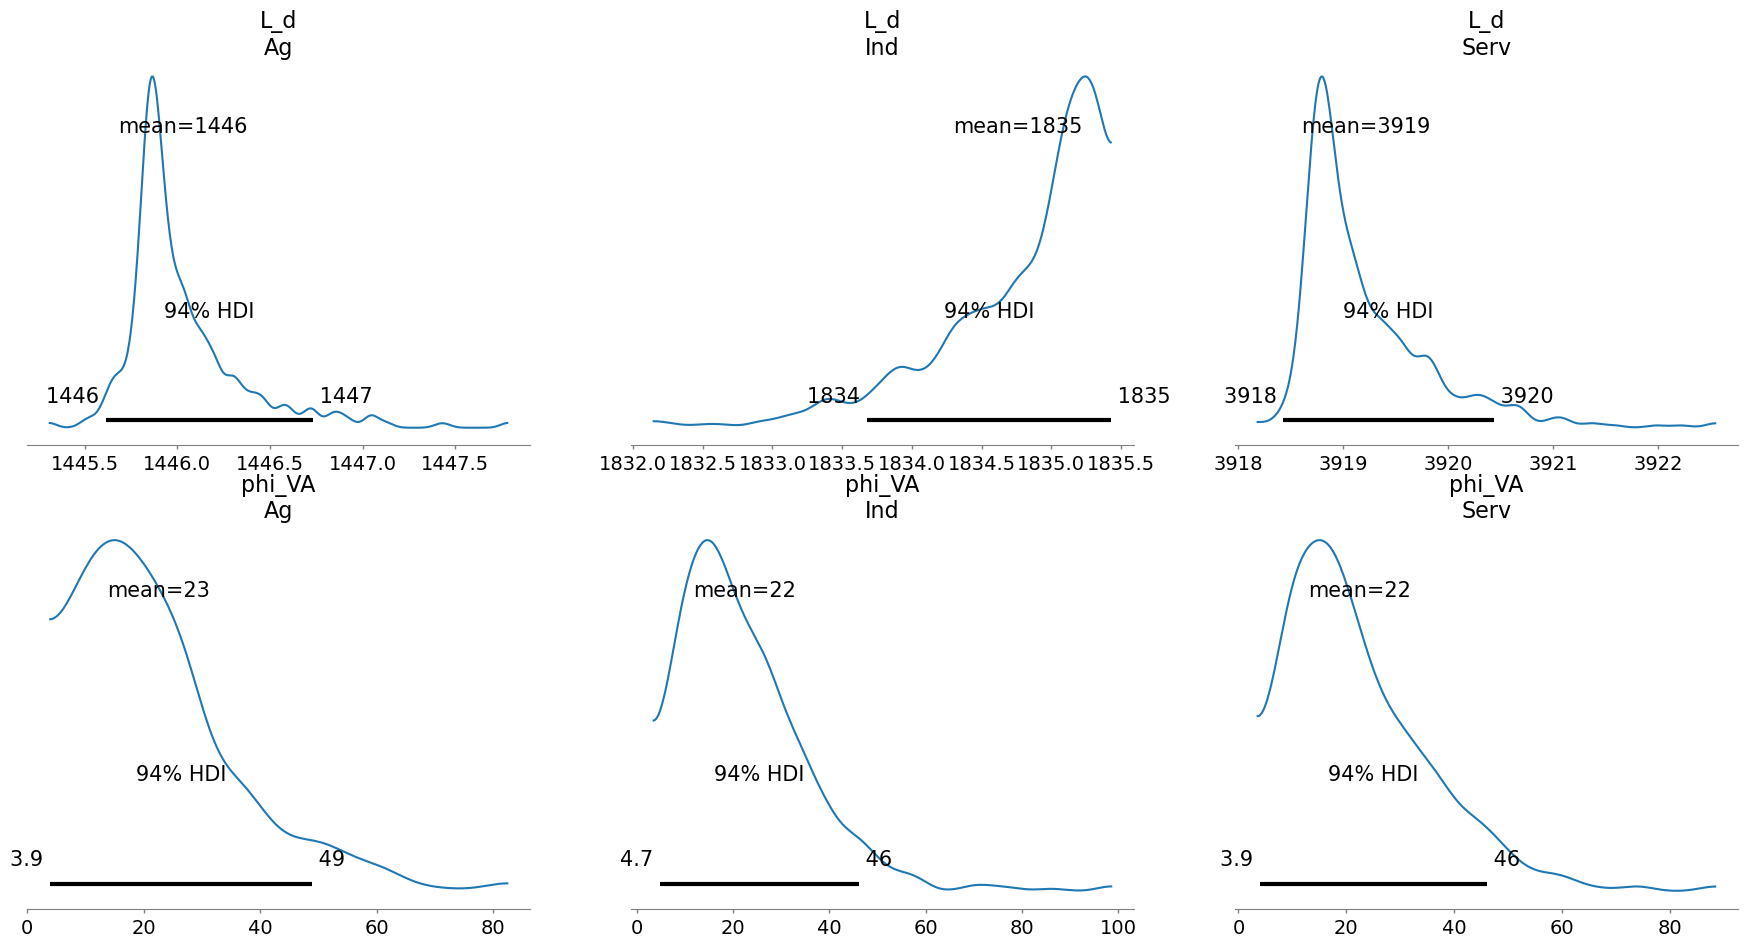

In [55]:
az.plot_posterior(idata.prior, var_names=["L_d", "phi_VA"])

## Missing Data Estimation

In [ ]:
with pm.Model(coords=coords) as m:
    f_model, f_jac, f_jac_inv = compile_cge_model_to_pytensor_Op(mod, inverse_method="solve")

    alpha = pm.Beta("alpha", 3, 3, dims=["sector"])
    alpha_k = pm.Dirchlet("alpha_k", a=[1, 1, 1], dims=["sector"])
    psi_VA = pm.Dirchlet("psi_VA", a=[1, 1, 1], dims=["sector"])
    psi_VC = pm.Dirchlet("psi_VC", a=[1, 1, 1], dims=["sector"])
    psi_X = pm.Dirchlet("psi_X", a=[1, 1, 1], dims=["sector", "sector_bis"])
    phi_VA_offset = pm.Gamma("phi_VA_offset", alpha=2, beta=0.1, dims=["sector"])
    phi_VA = pm.Deterministic("phi_VA", 3 + phi_VA_offset, dims=["sector"])

    tau = pm.Beta("tau", 1, 10, dims=["sector"])
    tau_income = pm.Beta("tau_income", 1, 10)
    gamma = pm.Dirchlet("gamma", a=[1, 1, 1], dims=["sector"])
    mps = pm.Beta("mps", 1, 5)
    alpha_G = pm.Dirchlet("alpha_G", a=[1, 1, 1], dims=["sector"])

    root_history, converged, step_size, n_steps = root(
        f_model, f_jac_inv, x0=x0, exog=params, tol=1e-8, max_iter=500
    )